In [94]:
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import geodatasets
import numpy as np
import math
import matplotlib.pyplot as plt
from shapely.geometry import LineString
import matplotlib.pyplot as plt
from tqdm import trange
import pickle
from concurrent.futures import ProcessPoolExecutor
from functools import partial
import os

In [95]:
"""
Classes
"""
class Cities:
    def __init__(self, csv):
        """
        Class containing all city objects

        Args:
        - Txt file containing cities and coordinates
        """
        # opens file
        with open(csv, "r") as f:
            lines = f.readlines()

        # reads all lines and adds them to a pandas table
        lines = lines[6:-1]
        stripped_lines = [line.strip() for line in lines]
        numbers = [[int(part) for part in line.split()] for line in stripped_lines]
        self.df = pd.DataFrame(numbers, columns=["city", "Longitude", "Latitude"])
        self.df = self.df.iloc[:, 1:]

        # add all city objects
        self.city = []
        for index, row in self.df.iterrows():
            self.city.append(City(row.name, row["Longitude"], row["Latitude"]))

class City:
    """
    Class to create one city object

    Args:
    - City integer
    - X coordinate
    - Y coordinate
    """
    def __init__(self, city, x, y):
        self.city = city
        self.x = x
        self.y = y
        self.connections = []

    def get_distance_to(self, city):
        """
        Euclidean distance to another city.

        Takes another city object and returns a distance between two cities
        """
        x2, y2 = city.x, city.y
        return np.sqrt((x2 - self.x)**2 + (y2 - self.y)**2)

    def __repr__(self):
        """
        For printing
        """
        return f"|City nr. {self.city} at x={self.x}, y={self.y}|"
    
class Route:
    """
    Class containing a certain route

    Args:
    - List[A,B] A = 1 B = The amount of cities in the route
    - Cities class, making it possible to link to all city objects
    - Perturbation, specifying the preferred perturbation when initializing
    """
    def __init__(self, list, cities_class, perturbation):
        self.cities = np.random.choice(range(list[1]), size=list[1], replace=False)
        self.route = []
        for i in self.cities:
            self.route.append(cities_class.city[i])
        self.distance = self.calculate_distance()
        self.old_route = []
        self.cities_class = cities_class
        self.perturbation = perturbation
        if self.perturbation == "two_opt":
            self.perturbation = self.two_opt
        elif self.perturbation == "move_single":
            self.perturbation = self.move_single
        else:
            raise ValueError("perturbation does not exist")


    def two_opt(self):
        """
        Performs 2-opt on the current route

        Saves the old route as well
        """
        self.old_route = self.route.copy()
        # choose two indices, ensuring they are non-adjacent
        while True:
            i, j = sorted(np.random.choice(len(self.route), size=2, replace=False))
            if j > i + 1:  
                break

        # reverse the segment between i and j
        self.route[i + 1:j + 1] = reversed(self.route[i + 1:j + 1])

    def move_single(self):
        """
        Moves a single city to another location in the route
        """
        self.old_route = self.route.copy()
        # random index to move
        from_index = np.random.randint(0, len(self.route) - 1)

        # new random location for the element
        to_index = np.random.randint(0, len(self.route) - 1)

        # remove the element at from_index
        element = self.route.pop(from_index)

        # insert the element at the new location
        self.route.insert(to_index, element)

    def calculate_distance(self):
        """
        Calculates the total distance of the route
        """
        distance = 0
        for i in range(len(self.route) - 1):
            distance += self.route[i].get_distance_to(self.route[i+1])
        distance += self.route[-1].get_distance_to(self.route[0])
        self.distance = distance
        return distance
    
    def plot(self):
        """
        plots the route

        From: https://stackoverflow.com/questions/53233228/plot-latitude-longitude-from-csv-in-python-3-6
        """

        geometry = [Point(xy) for xy in zip(self.cities_class.df['Longitude'], self.cities_class.df['Latitude'])]
        gdf = GeoDataFrame(self.cities_class.df, geometry=geometry)   

        world = gpd.read_file(geodatasets.data.naturalearth.land['url'])

        gdf_filtered = gdf[(gdf['Longitude'] > 0) & (gdf['Latitude'] > 0)]
        minx, miny, maxx, maxy = gdf_filtered.total_bounds  

        route_coordinates = [(city.x, city.y) for city in self.route]
        route_coordinates.append((self.route[0].x, self.route[0].y))

        # create a GeoDataFrame for the route as a LineString
        route_line = LineString(route_coordinates)
        route_gdf = gpd.GeoDataFrame(geometry=[route_line])

        # awesome world map 
        ax = world.plot(figsize=(15, 20), color='gray')
        # cities
        gdf_filtered.plot(ax=ax, marker='o', color='black', markersize=20)
        # route
        route_gdf.plot(ax=ax, color='blue', linewidth=1)

        # for i, city in enumerate(cities):
        #     plt.text(city.x, city.y, str(i + 1), fontsize=8, color="black")

        ax.set_xlim(minx - 10, maxx + 5)
        ax.set_ylim(miny - 5, maxy + 10)

        plt.title("Salesman's Route")
        plt.show()
    
    def __repr__(self):
        """
        For printing
        """
        return f"route goes through {len(self.route)} cities"

In [96]:
def load_tour(tour_file):
    """
    Load the optimal tour from the TSP tour file.
    """
    tour = []
    with open(tour_file, "r") as file:
        lines = file.readlines()
        tour_section = False
        for line in lines:
            if "TOUR_SECTION" in line:
                tour_section = True
                continue
            if tour_section:
                city_id = int(line.strip())
                if city_id == -1:
                    break
                tour.append(city_id)
    return tour

load_tour('eil51.opt.tour.txt')

[1,
 22,
 8,
 26,
 31,
 28,
 3,
 36,
 35,
 20,
 2,
 29,
 21,
 16,
 50,
 34,
 30,
 9,
 49,
 10,
 39,
 33,
 45,
 15,
 44,
 42,
 40,
 19,
 41,
 13,
 25,
 14,
 24,
 43,
 7,
 23,
 48,
 6,
 27,
 51,
 46,
 12,
 47,
 18,
 4,
 17,
 37,
 5,
 38,
 11,
 32]

In [97]:
cities = Cities("a280.tsp.txt")
route = Route([1,280], cities, "two_opt")
print(route.route)



[|City nr. 31 at x=104, y=169|, |City nr. 6 at x=236, y=169|, |City nr. 240 at x=284, y=101|, |City nr. 109 at x=56, y=57|, |City nr. 56 at x=32, y=121|, |City nr. 271 at x=204, y=145|, |City nr. 83 at x=32, y=73|, |City nr. 117 at x=56, y=97|, |City nr. 279 at x=280, y=133|, |City nr. 43 at x=40, y=121|, |City nr. 278 at x=260, y=129|, |City nr. 8 at x=228, y=161|, |City nr. 100 at x=56, y=17|, |City nr. 198 at x=172, y=45|, |City nr. 26 at x=132, y=169|, |City nr. 235 at x=284, y=61|, |City nr. 70 at x=8, y=89|, |City nr. 1 at x=288, y=129|, |City nr. 171 at x=80, y=25|, |City nr. 168 at x=64, y=21|, |City nr. 65 at x=24, y=89|, |City nr. 69 at x=8, y=97|, |City nr. 155 at x=124, y=101|, |City nr. 159 at x=104, y=65|, |City nr. 136 at x=172, y=101|, |City nr. 137 at x=172, y=93|, |City nr. 199 at x=180, y=45|, |City nr. 211 at x=228, y=61|, |City nr. 212 at x=228, y=53|, |City nr. 276 at x=246, y=141|, |City nr. 113 at x=56, y=73|, |City nr. 234 at x=284, y=53|, |City nr. 114 at x=56

37
42.04759208325728
1599.4417315213263


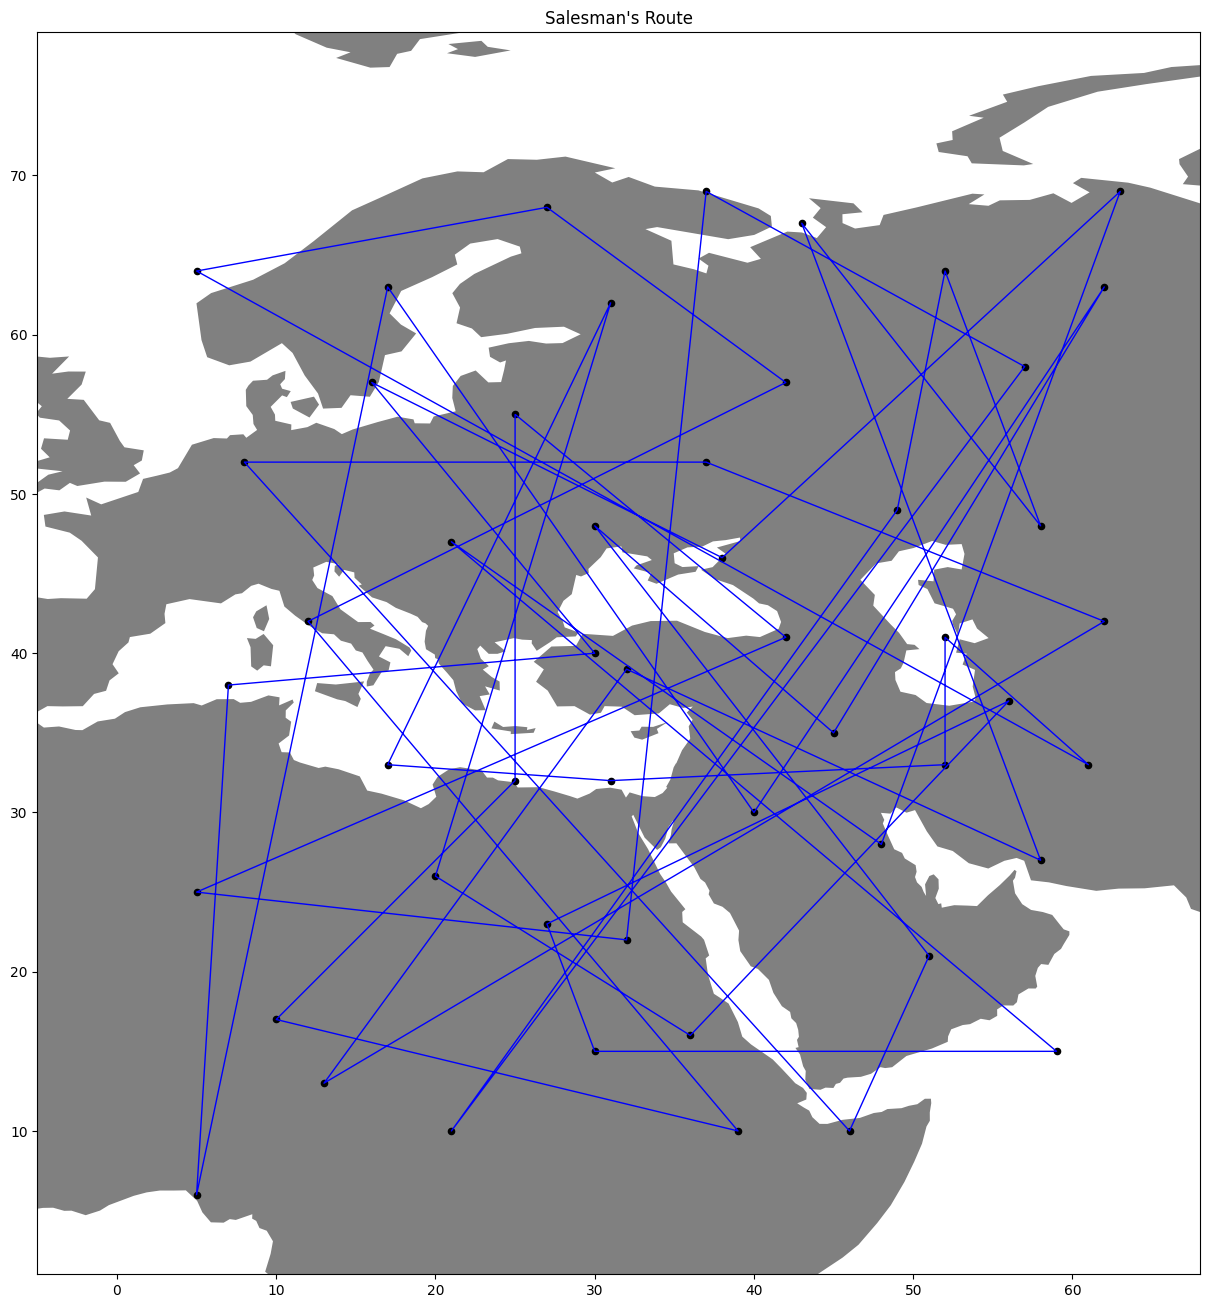

In [98]:
"""
USAGE EXAMPLES
"""
cities = Cities("eil51.tsp.txt")

print(cities.city[0].x)
print(cities.city[0].get_distance_to(cities.city[44]))

# define as the first city to the 51st city
route = Route([1,51], cities, "two_opt")
print(route.calculate_distance())
route.two_opt()
route.plot()

In [99]:
"""
Simulated Annealing
"""
class SimmulatedAnnealing:
    """
    Class for simmulated Annealing

    Args:
    - The amount of cities in the txt file
    - txt file with the cities

    Usage:
    annealing = SimmulatedAnnealing(x,x)
    ...
    specify parameters
    ...
    annealing.run(y), where y is the amount of different runs 

    Notes:
    - Set all preferred variables beforehand otherwise it will take default values
    """
    def __init__(self, cities_amount,csv):
        self.init_temp = 1
        self.final_temp = 0.01
        self.cooling_rate = 0.95
        self.iterations = 100
        self.cities_amount = cities_amount
        self.cities = Cities(csv)
        self.mean = []
        self.sd = []
        self.data = []
        self.final_routes = []
        self.measurement_interval = 1
        self.perturbation = "two_opt"
        self.cooling_method = self.cooling_linear
        self.markov_chain = 1

        self.temp_data = None

    def run(self, runs):
        """
        Runs annealing
        """
        if self.iterations % self.measurement_interval != 0:
            raise ValueError("Iterations divided by measurement interval must be a whole number")

        self.data = np.zeros((runs, int(self.iterations/self.measurement_interval)))
        self.temp_data = np.zeros((runs, int(self.iterations/self.measurement_interval)))
        

        for i in trange(runs):
            # if i % 5 == 0:
            #     print(f"run {i} with {self.perturbation}")
            solutions_list = np.zeros(int(self.iterations/self.measurement_interval))
            temperature_list = np.zeros(int(self.iterations/self.measurement_interval))
            # create new route
            input = [1,self.cities_amount], self.cities, self.perturbation
            route = Route([1,self.cities_amount], self.cities, self.perturbation)
            current_solution = route.calculate_distance()
            solutions_list[0] = current_solution
            current_temp = self.init_temp
            temperature_list[0] = current_temp
            # temperatures = [current_temp]

            # iterate until the temperature is below the final temperature
            # while current_temp > self.final_temp:
            for j in range(1, self.iterations):
                # perturb 
                route.perturbation()
                perturbed_solution = route.calculate_distance()

                # define delta and accepting probability
                delta = perturbed_solution - current_solution
                exponent = min(-delta / current_temp, 700)
                probability = math.exp(exponent) 

                # if perturbed solution is better accept it as the new solution
                if delta < 0: 
                    current_solution = perturbed_solution
                # if it is worse accept it with certain probability
                elif np.random.random() < probability:
                    current_solution = perturbed_solution
                else:
                    route.route = route.old_route.copy()
                    current_solution = route.calculate_distance()

                # decrease temperature according to cooling rate
                # decrease temperature according to cooling rate
                if j % self.markov_chain == 0:  
                    if self.cooling_method == self.cooling_logarithmic:
                        current_temp = self.cooling_method(self.init_temp, self.final_temp, j, self.iterations)
                    else:
                        current_temp = self.cooling_method(self.init_temp, self.final_temp, j, self.iterations)

               
                # if current_temp < self.final_temp:
                #     break
                if j % self.measurement_interval == 0:
                    solutions_list[int(j/self.measurement_interval)] = current_solution
                    temperature_list[int(j/self.measurement_interval)] = current_temp

                # temperatures.append(current_temp)
            
            self.final_routes.append(route)
            self.data[i] = solutions_list
            self.temp_data[i] = temperature_list

    def give_sd_at(self, iteration):
        """
        Returns standard deviation at a certain iteration

        IMPORTANT NOTE: make sure that iteration / measurement_interval exists
        """
        iteration = iteration / self.measurement_interval
        return np.std(self.data[:, iteration])

    def give_mean_at(self, iteration):
        """
        Returns mean at a certain iteration

        IMPORTANT NOTE: make sure that iteration / measurement_interval exists
        """
        iteration = iteration / self.measurement_interval
        return np.mean(self.data[:, iteration])

    def give_all_means(self):
        """
        Returns means over all runs at all iterations in a list 
        """
        return np.mean(self.data, axis=0).tolist()
    
    def give_all_temps_mean(self):
        return np.mean(self.temp_data, axis=0).tolist()

    def give_all_sd(self):
        """
        Returns standard deviation over all runs at all iterations in a list
        """
        return np.std(self.data, axis=0).tolist()
    
    def give_ci_at(self, iteration):
        """
        Returns confidence interval at a certain iteration

        IMPORTANT NOTE: make sure that iteration / measurement_interval exists
        """
        iteration = iteration / self.measurement_interval
        std_dev = np.std(self.data[:, iteration])
        n = self.data.shape[0] 
        return (1.96 * std_dev / np.sqrt(n))

    def give_all_ci(self):
        """
        Returns confidence interval over all runs at all iterations in a list
        """
        std_devs = np.std(self.data, axis=0)
        n = self.data.shape[0]
        print(n)  
        return (1.96 * std_devs / np.sqrt(n)).tolist()
    
    def range(self):
        """
        Returns the amount of datapoints 

        Note: useful for plotting
        """
        return int(self.iterations/self.measurement_interval)
    
    @staticmethod
    def cooling_linear(temp_start, final_temp, iteration, iterations):
        new_temp = temp_start - iteration * (temp_start - final_temp)/iterations
        return new_temp
    
    @staticmethod
    def cooling_exponential(temp_start, final_temp, iteration, iterations):
        a = (final_temp / temp_start) ** (1 / iterations)
        T = temp_start * (a ** iteration)
        
        return T
    
    
    @staticmethod
    def cooling_logarithmic(temp_start, final_temp, iteration, iterations):
        # C = temp_start * np.log(1 + iterations) / (temp_start - final_temp)
        # T = C / np.log(1 + iterations)
        # C = temp_start * np.log(1 + iterations)
        # T = C / np.log(1 + iteration)

        scale = math.log(1 + iterations)  # Scaling factor for the entire process
        current_log = math.log(1 + iteration)  # Current logarithmic value
        temp = final_temp + (temp_start - final_temp) * (scale - current_log) / scale

        
        return temp

    def set_cooling_method(self, method):
        if method == "linear":
            self.cooling_method = self.cooling_linear
        elif method == "exponential":
            self.cooling_method = self.cooling_exponential
        elif method == "logarithmic":
            self.cooling_method = self.cooling_logarithmic
        else:
            raise ValueError(f"Unknown cooling method: {method}")


In [100]:
"""
Using it
"""
cooling_rates = [0.999, 0.95, 0.9]

two_opt_list = []
move_single_list = []

for i in range(len(cooling_rates)):
    annealing = SimmulatedAnnealing(51, "eil51.tsp.txt")
    annealing.cooling_rate = cooling_rates[i]
    annealing.final_temp = 0.0001
    annealing.init_temp = 2
    annealing.iterations = 5000
    annealing.measurement_interval = 10
    annealing.perturbation = "two_opt"
    annealing.run(10)
    two_opt_list.append(annealing)

    annealing_move = SimmulatedAnnealing(51, "eil51.tsp.txt")
    annealing_move.cooling_rate = cooling_rates[i]
    annealing_move.init_temp = 2
    annealing_move.iterations = 5000
    annealing_move.measurement_interval = 10
    annealing_move.perturbation = "move_single"
    annealing_move.run(10)
    move_single_list.append(annealing_move)


100%|██████████| 10/10 [00:07<00:00,  1.33it/s]


10
10
10
10
10
10


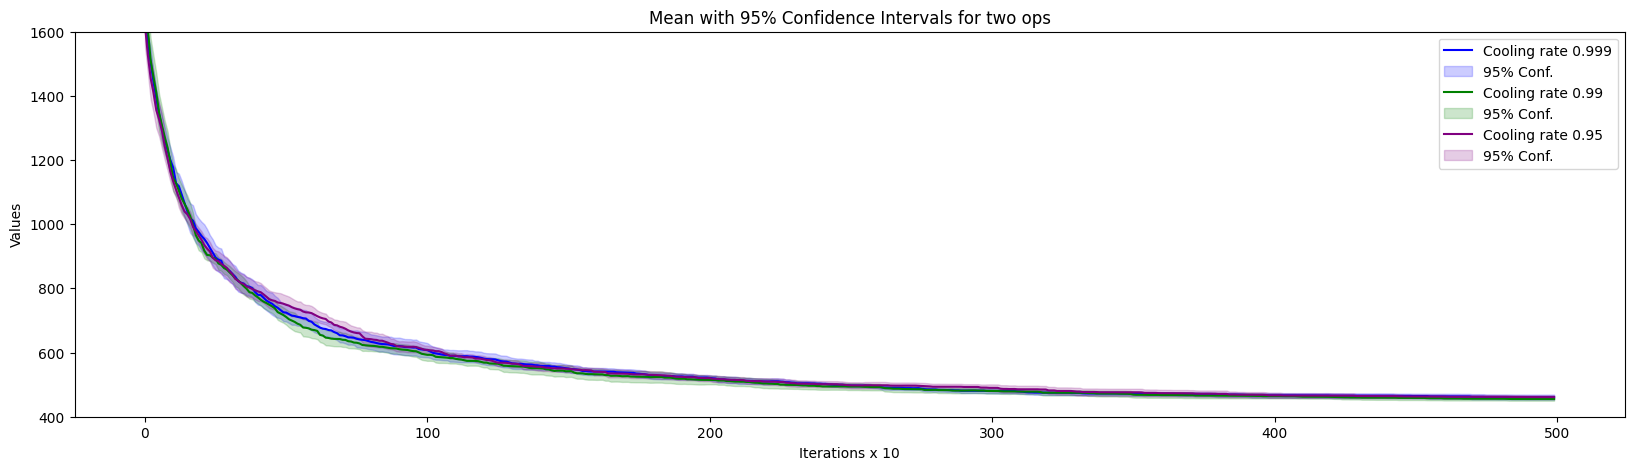

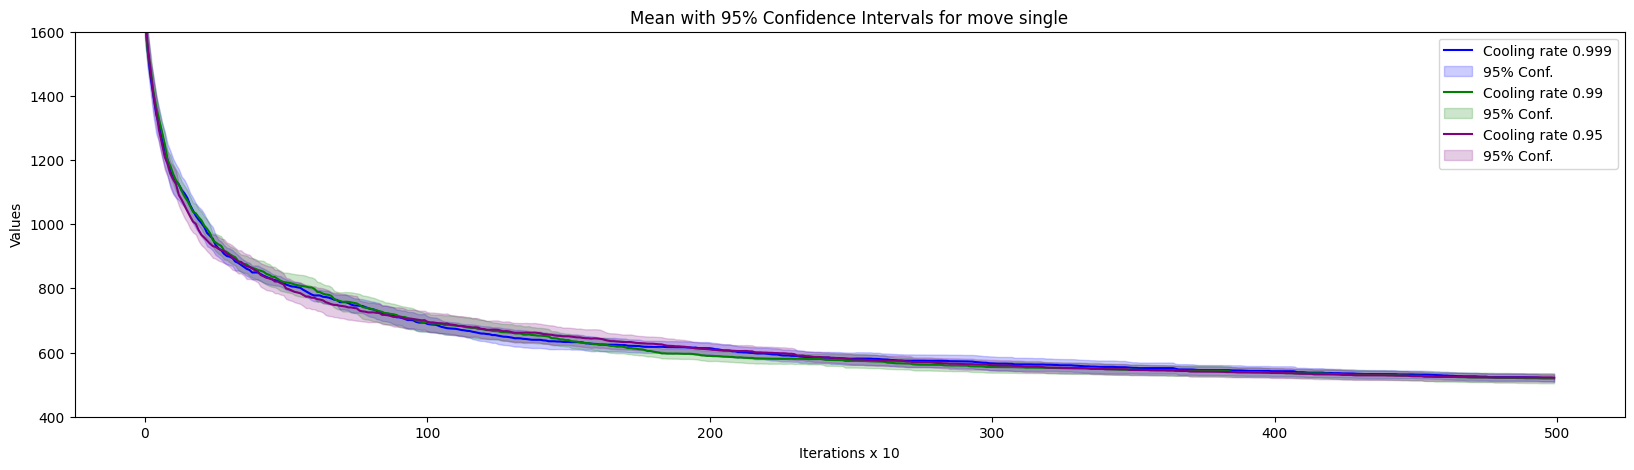

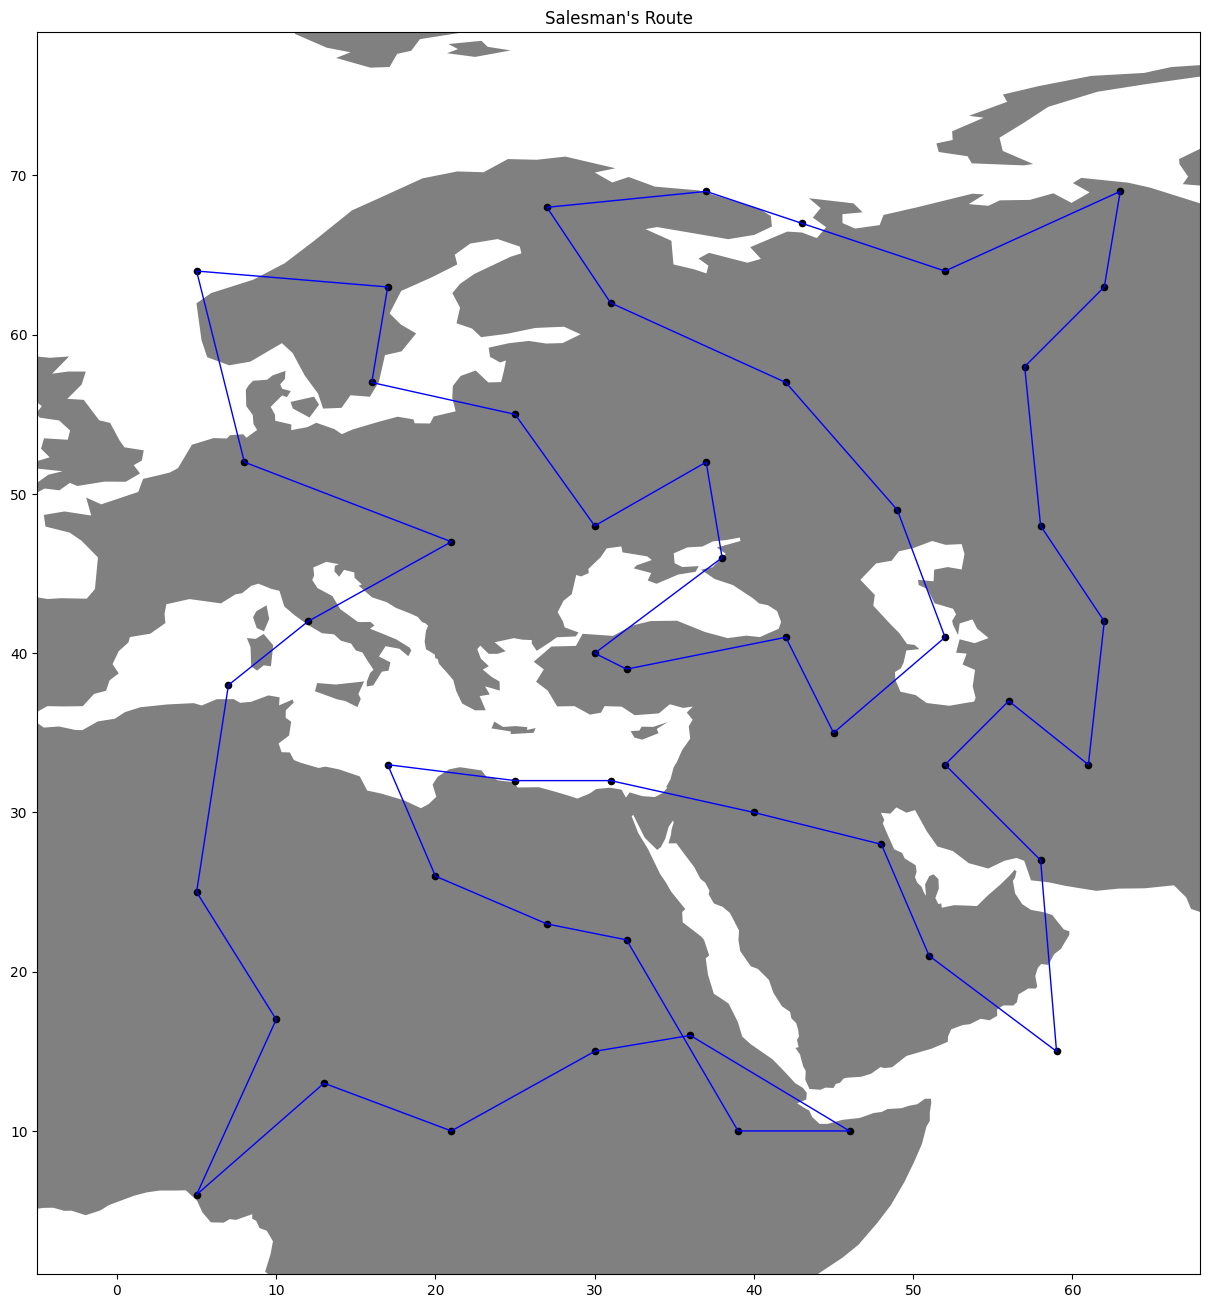

In [101]:
means_two = [two_opt_list[0].give_all_means(), two_opt_list[1].give_all_means(), two_opt_list[2].give_all_means()]
means_single = [move_single_list[0].give_all_means(), move_single_list[1].give_all_means(), move_single_list[2].give_all_means()]
ci_two = [two_opt_list[0].give_all_ci(), two_opt_list[1].give_all_ci(), two_opt_list[2].give_all_ci()]
ci_single = [move_single_list[0].give_all_ci(), move_single_list[1].give_all_ci(), move_single_list[2].give_all_ci()]

iterations = range(two_opt_list[0].range())  

colors = ["blue","green","purple"]
cooling_rates = [0.999, 0.99, 0.95]

plt.figure(figsize=(20,5))
for i, mean in enumerate(means_two):
    plt.plot(iterations, mean, label=f"Cooling rate {cooling_rates[i]}", color=colors[i])


    plt.fill_between(
        iterations,
        np.array(mean) - np.array(ci_two[i]),  
        np.array(mean) + np.array(ci_two[i]),  
        color=colors[i],
        alpha=0.2,  
        label="95% Conf."
    )

plt.xlabel(f"Iterations x {annealing.measurement_interval}")
plt.ylabel("Values")
plt.title("Mean with 95% Confidence Intervals for two ops")
plt.legend()
plt.ylim(400, 1600)

plt.show()

plt.figure(figsize=(20,5))
for i, mean in enumerate(means_single):
    plt.plot(iterations, mean, label=f"Cooling rate {cooling_rates[i]}", color=colors[i])


    plt.fill_between(
        iterations,
        np.array(mean) - np.array(ci_single[i]),  
        np.array(mean) + np.array(ci_single[i]),  
        color=colors[i],
        alpha=0.2,  
        label="95% Conf."
    )

plt.xlabel(f"Iterations x {annealing.measurement_interval}")
plt.ylabel("Values")
plt.title("Mean with 95% Confidence Intervals for move single")
plt.legend()
plt.ylim(400, 1600)

plt.show()

annealing.final_routes[5].plot()



In [102]:
class City:
    def __init__(self, city, x, y):
        """
        - city: city integer
        - x coordinate
        - y coordinate
        """
        self.city = city
        self.x = x
        self.y = y
        self.connections = []

    def get_distance_to(self, city):
        """
        Euclidean distance to another city.

        Takes another city object and returns a distance between two cities
        """
        x2, y2 = city.x, city.y
        return np.sqrt((x2 - self.x)**2 + (y2 - self.y)**2)
    
    def connects_to(self, city):
        """
        Connects one city to another by adding it to a list
        """
        self.connections.append(city)

    def __repr__(self):
        """
        For printing
        """
        return f"|City nr. {self.city} at x={self.x}, y={self.y}|"
    
class Route:
    def __init__(self, route, cities):
        self.cities = cities
        self.route = [self.cities[i] for i in route]
        self.route_int = route
        self.distance = self.calculate_distance()
        self.old_route = []

    def two_opt(self):
        """
        """
        self.old_route = self.route
        # choose two indices, ensuring they are non-adjacent
        while True:
            i, j = sorted(np.random.choice(len(self.route), size=2, replace=False))
            if j > i + 1:  
                break

        # reverse the segment between i and j
        self.route[i + 1:j + 1] = reversed(self.route[i + 1:j + 1])
        self.route_int[i + 1:j + 1] = reversed(self.route_int[i + 1:j + 1])

    def calculate_distance(self):
        distance = 0
        for i in range(len(self.route) - 1):
            distance += self.route[i].get_distance_to(self.route[i+1])
        distance += self.route[-1].get_distance_to(self.route[0])
        return distance
    
    def plot(self):
        route_coordinates = [(city.x, city.y) for city in self.cities]

        # Create a GeoDataFrame for the route as a LineString
        route_line = LineString(route_coordinates)
        route_gdf = gpd.GeoDataFrame(geometry=[route_line])

        # awesome world map 
        ax = world.plot(figsize=(15, 20), color='gray')
        # cities
        gdf_filtered.plot(ax=ax, marker='o', color='blue', markersize=15)
        # route
        route_gdf.plot(ax=ax, color='red', linewidth=2)

        # for i, city in enumerate(cities):
        #     plt.text(city.x, city.y, str(i + 1), fontsize=8, color="black")

        ax.set_xlim(minx - 10, maxx + 5)
        ax.set_ylim(miny - 5, maxy + 10)

        plt.title("Salesman's Route")
        plt.show()
    
    def __repr__(self):
        """
        For printing
        """
        return f"route goes through {len(self.route)} cities"

In [103]:
methods_test = ["linear", "exponential", "logarithmic"]
results_test = {m: {} for m in methods_test}
temp_results_test = {m: {} for m in methods_test}
all_runs_data_test = {}


In [104]:

def run_simulation(method, cooling_rate=0.95):
    annealing = SimmulatedAnnealing(280, "a280.tsp.txt")
    annealing.set_cooling_method(method)
    annealing.init_temp = 400
    annealing.final_temp = 1
    annealing.iterations = 100
    annealing.measurement_interval = 10
    annealing.perturbation = "two_opt"
    annealing.cooling_rate = cooling_rate
    
    print(f"Method: {method}")
    annealing.run(10)
    
    mean_values = annealing.give_all_means()
    mean_temps = annealing.give_all_temps_mean()
    data = annealing.data
    
    return method, mean_values, mean_temps, data

# with ProcessPoolExecutor(max_workers=2) as executor:
#     # Use partial to pass the cooling_rate if needed
#     tasks = {executor.submit(run_simulation, method): method for method in methods}
    
#     for future in tasks:
#         method, mean_values, mean_temps, data = future.result()
#         results[method] = mean_values
#         temp_results[method] = mean_temps
#         all_runs_data[method] = data
for method in methods_test:
    
    annealing = SimmulatedAnnealing(280, "a280.tsp.txt")
    annealing.set_cooling_method(method)
    annealing.init_temp = 400
    annealing.final_temp = 1
    annealing.iterations = 100
    annealing.measurement_interval = 10
    annealing.perturbation = "two_opt"
    annealing.cooling_rate = 0.95
    print(f"Method: {method} ")
    
    annealing.run(10)
    mean_values = annealing.give_all_means()
    mean_temps = annealing.give_all_temps_mean()
    results_test[method] = mean_values
    temp_results_test[method] = mean_temps
    all_runs_data_test[method] = annealing.data


Method: linear 


  0%|          | 0/10 [00:00<?, ?it/s]


TypeError: Route.__init__() takes 3 positional arguments but 4 were given

In [20]:
with open("results_1mil_cooling_with_annealing.pkl", "wb") as file:
    pickle.dump((results, temp_results, all_runs_data), file)
    

In [18]:
bestand = "results_1mil_cooling.pkl"

if os.path.exists(bestand):
    try:
        with open(bestand, "rb") as file:
            results, temp_results = pickle.load(file)
        print("Data succesvol geladen.")
    except Exception as e:
        print(f"Er is een fout opgetreden bij het laden van de data: {e}")
else:
    print(f"Het bestand {bestand} bestaat niet.")

Data succesvol geladen.


In [14]:
print(results["linear"])

[34272.29006144833, 33979.73496178832, 33828.433735743565, 33726.75292762002, 33442.735659184385, 33481.1854187572, 33217.8097677444, 32903.32661337283, 32735.548045914165, 32685.808565155974, 32628.080510031305, 32788.619041027596, 32746.932068995695, 32763.646974701704, 32644.045273823995, 32599.61353227636, 32556.62577821641, 32478.931451755932, 32516.460588206108, 32328.347741212863, 32194.335727689206, 32014.90949360907, 32053.822213614632, 32145.677208257617, 32172.462699004478, 32180.037442259294, 32202.073628092032, 32216.267201881557, 32112.590900790994, 31991.583316518045, 32225.491193572805, 32154.008700251383, 31946.0034819659, 31865.549203704817, 31870.202535021777, 31646.141642410446, 31614.825986606942, 31614.14675264828, 31550.620514413808, 31576.463039721148, 31459.743705966102, 31466.592113985003, 31463.84693388188, 31664.69638845353, 31625.199342921995, 31665.746657692776, 31781.92334945467, 31975.600951747336, 31876.587208701327, 31856.769629533905, 31764.0135229626

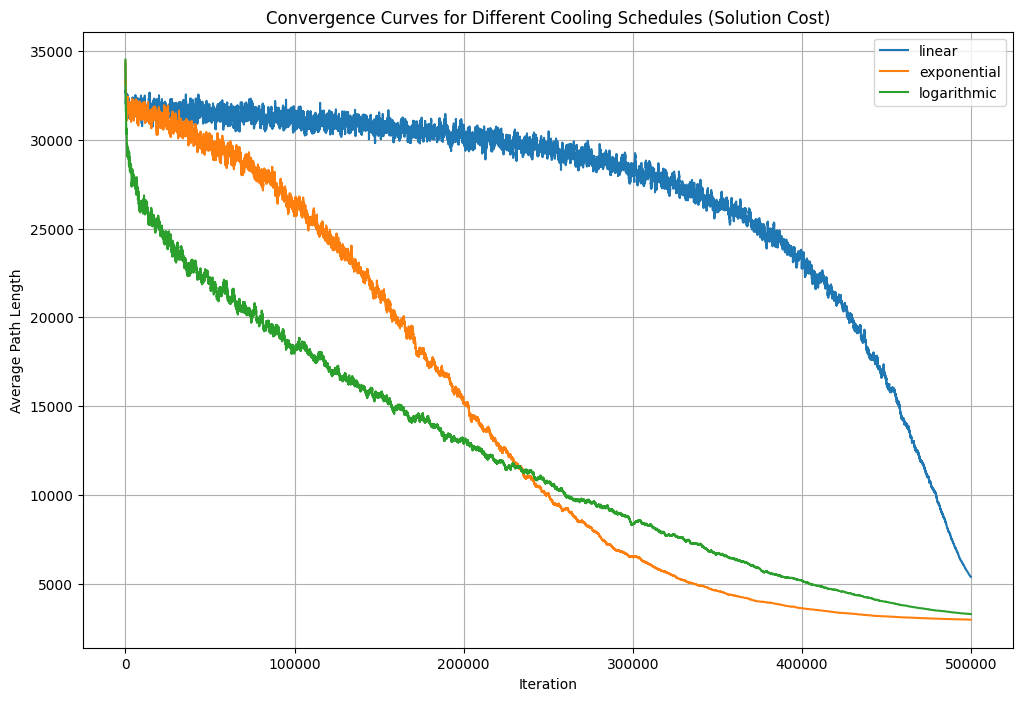

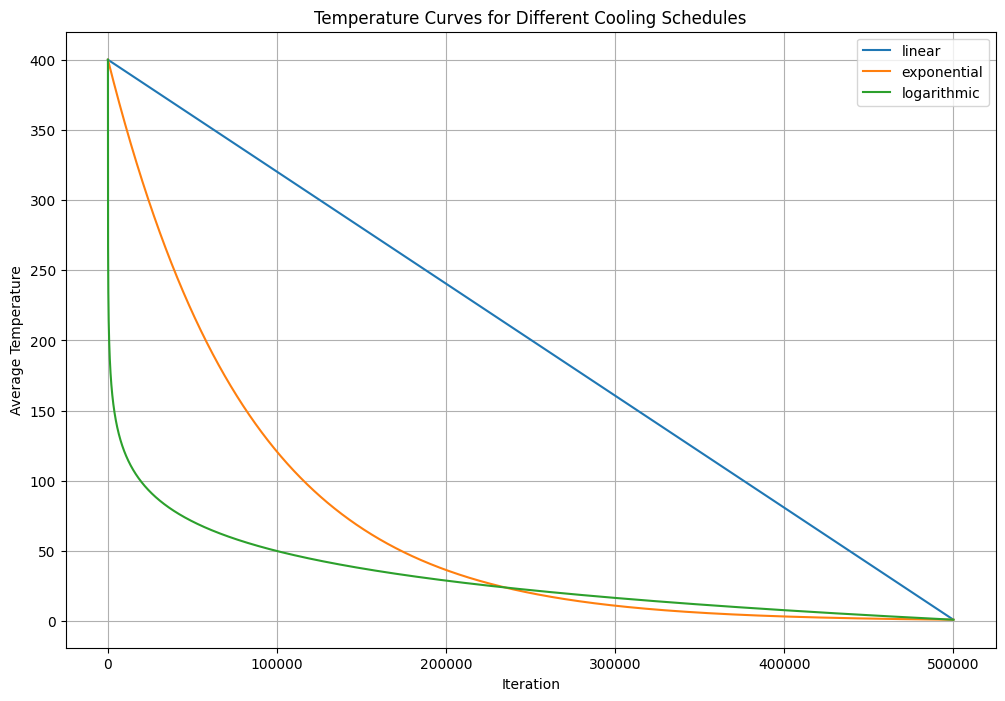

In [19]:
# Plotting convergence curves (solution cost)
plt.figure(figsize=(12, 8))
x_axis = np.arange(0, 500000, 10)  # since measurement_interval=10
for method in methods:
    plt.plot(x_axis, results[method], label=f"{method}")

plt.title("Convergence Curves for Different Cooling Schedules (Solution Cost)")
plt.xlabel("Iteration")
plt.ylabel("Average Path Length")
plt.legend()
plt.grid(True)
plt.show()

# Plotting temperature curves
plt.figure(figsize=(12, 8))
for method in methods:
    plt.plot(x_axis, temp_results[method], label=f"{method}")

plt.title("Temperature Curves for Different Cooling Schedules")
plt.xlabel("Iteration")
plt.ylabel("Average Temperature")
plt.legend()
plt.grid(True)
plt.show()
